In [18]:
import numpy as np 
import glob
from myvtk.GetMakeVtk import GetMyVtk, makeVtkFile, measure_length
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from PIL import Image, ImageDraw, ImageFont
import cv2

from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from myvtk.srv import square_root_velocity

from sklearn.decomposition import PCA

Standardization = z-score normalization, 元データの平均を0に、標準偏差が1に変換する。


$
x_{new}^{i}=\frac{x^i-\mu}{\sigma}
$

(104, 64, 3)
(104, 64, 3)


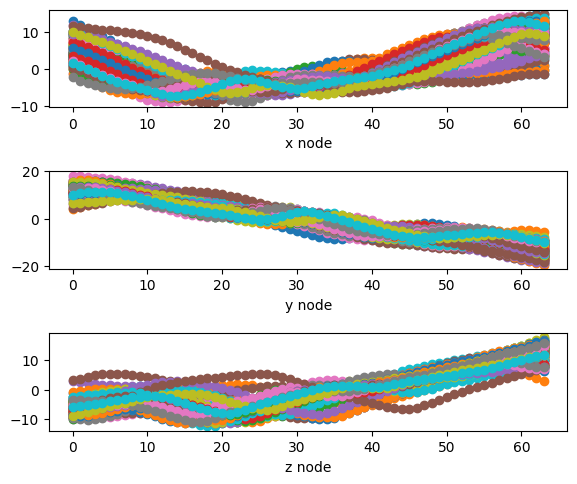

In [19]:
files = glob.glob("./scaling/resamp_attr_ascii/vmtk64a/*.vtk")

#########################################
#    vmtkで計算したcurv, torsを使う      #
#       0.5mmまでresamplingした         # 
#########################################
# files = (glob.glob(".\\scaling\\resamp_attr_ascii\\vmtkgeometry\\*.vtk"))


r = []
pts = []
PTN = []
curvs = []
torss = []
abscs = [] 
Tangents = []
for i in range(len(files)): 
    pt, Curv, Tors, Radius, Abscissas, ptns, ftangent = GetMyVtk(files[i], frenetTangents=1)
    if len(pt) != 64:
        print (len(pt), files[i])
        continue
    centroid = np.array([np.mean(pt[:,0]),np.mean(pt[:,1]),np.mean(pt[:,2])])
    pt = pt-centroid
    pts.append(pt)
    r.append(Radius)
    PTN.append(ptns)
    curvs.append(Curv)
    torss.append(Tors)
    abscs.append(Abscissas)
    Tangents.append(ftangent)
pts = np.array(pts)
r = np.array(r)
PTN = np.array(PTN)
curvs=np.array(curvs)
torss = np.array(torss)
abscs= np.array(abscs)
Tangents = np.array(Tangents)

fig = plt.figure(figsize=(6, 5))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.set_xlabel("x node")
ax2.set_xlabel("y node")
ax3.set_xlabel("z node")
plt.tight_layout()
for i in range(100):
    ax1.scatter(range(len(pts[i])), pts[i,:,0])
    ax2.scatter(range(len(pts[i])), pts[i,:,1])
    ax3.scatter(range(len(pts[i])), pts[i,:,2])
plt.savefig("experiment_note/img/og_coord.png")

print (Tangents.shape)
print (PTN.shape)

In [20]:
torsion_inverse = []

###################################################
#    torsion_inverse: [vessel_idx, node1, node2]  #
#    t_inverse:[0:non-inversed,                   #
#                1:inversed;                      #
#                location:idx]                    #
###################################################

filtered = 0
for i in range(len(pts)): 
    #if max(curvs[i])<1.0 and max(abs(torss[i]))<1.0:
    if 1:
        for j in range(1, len(curvs[i])-1 ):
            if curvs[i][j] > 0.3 :
                if torss[i][j]*torss[i][j+1]<0:
                    torsion_inverse.append([i, j, j+1])
                elif torss[i][j-1]*torss[i][j]<0 and [i, j-1, j] not in torsion_inverse:
                    torsion_inverse.append([i, j-1, j])
    else:
        filtered+=1

print (filtered)

torsion_inverse = np.array(torsion_inverse)
# print( torsion_inverse)

################################################
#         分成有inverse和无inverse　　　　　　　 #
################################################

t_inverse = np.zeros_like(range(len(files)))
# print (torsion_inverse[:,0])

t_inverse[torsion_inverse[:,0]]=1
print (t_inverse)

0
[1 1 0 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]


In [23]:
from scipy.spatial.transform import Rotation
# from skopt import gp_minimize
from scipy.optimize import minimize

print (Rotation.random().as_matrix().shape)

curve = pts[16]

def distance_curve2yz(curve):
    d = 0
    for i in range(len(curve)):
        # p_on_yx = (0, curve[i][1],curve[i][2])
        d = d + abs(curve[i,0])
    return d


def rotate_curve(curve, quat):
    rot = Rotation.from_quat(quat)
    return (rot.apply(curve))

def opt_distance(quat):
    c = curve
    return distance_curve2yz(rotate_curve(c, quat))

res = minimize(opt_distance, x0=Rotation.random().as_quat(), method='Nelder-Mead')
print (res.x)
#print (res)

new_curve = rotate_curve(curve, res.x)

(3, 3)
[0.58577526 1.21680643 0.4403123  0.512344  ]


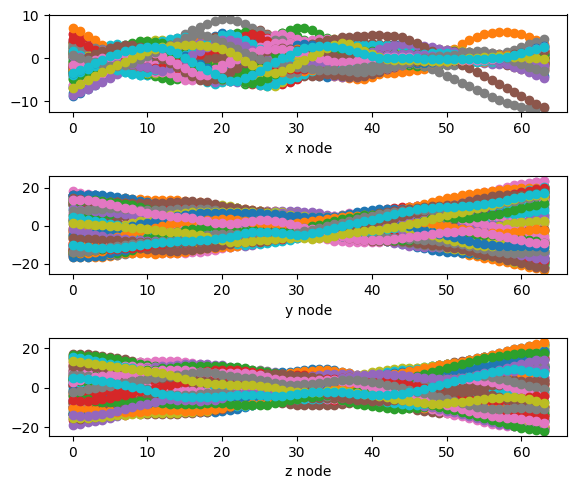

In [24]:
new_pts = []

for i in range(len(pts)):
    curve = pts[i]
    res = minimize(opt_distance, x0=Rotation.random().as_quat(), method='Nelder-Mead')
    # print (res.x)
    #print (res)
    new_curve = rotate_curve(curve, res.x)
    new_pts.append(new_curve)

new_pts = np.array(new_pts)


fig = plt.figure(figsize=(6, 5))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.set_xlabel("x node")
ax2.set_xlabel("y node")
ax3.set_xlabel("z node")
plt.tight_layout()
for i in range(100):
    ax1.scatter(range(len(new_pts[i])), new_pts[i,:,0])
    ax2.scatter(range(len(new_pts[i])), new_pts[i,:,1])
    ax3.scatter(range(len(new_pts[i])), new_pts[i,:,2])
# plt.savefig("experiment_note/img/rot_coord.png")

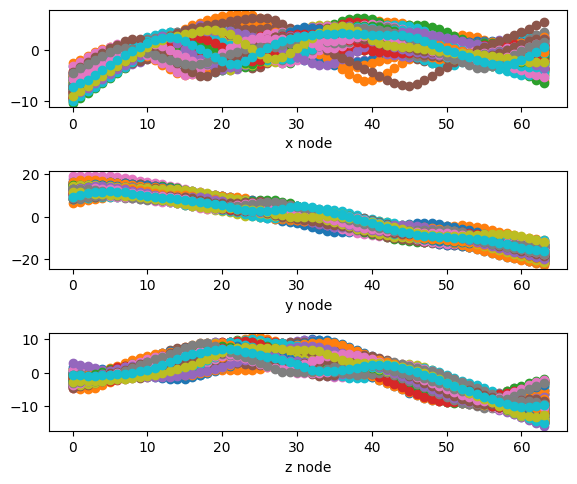

In [25]:
from procrustes import rotational

v1 = 0
v2 = 0
aligned_pts = []
aligned_pts.append(new_pts[0,:,:])
for i in range(1, len(new_pts)):
    result_rot = rotational(new_pts[i,:,:], new_pts[0,:,:], translate=False, scale=False)
    # aligned_pts.append(result_rot.new_a)
    aligned_pts.append(np.dot(result_rot.new_a, result_rot.t))
    scalarAttribute= [['MaximumInscribedSphereRadius', 'float', r[i]]]
    # makeVtkFile(savePath = "D:\\!BraVa_src\\src\\ModeDecomposition\\rot_alignment\\"+files[i].split("\\")[-1],
    #             coords = np.dot(result_rot.new_a, result_rot.t),
    #             scalarAttributes=scalarAttribute,
    #             fieldAttributes=[] )



aligned_pts = np.array(aligned_pts)

# fig = plt.figure(figsize=(6, 5))
# ax = fig.add_subplot(111, projection='3d')
# for i in range(100):
#     ax.plot(aligned_pts[i,:,0], aligned_pts[i,:,1], aligned_pts[i,:,2])
# ax.view_init(v1, v2)

fig = plt.figure(figsize=(6, 5))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.set_xlabel("x node")
ax2.set_xlabel("y node")
ax3.set_xlabel("z node")
plt.tight_layout()
for i in range(100):
    ax1.scatter(range(len(aligned_pts[i])), aligned_pts[i,:,0])
    ax2.scatter(range(len(aligned_pts[i])), aligned_pts[i,:,1])
    ax3.scatter(range(len(aligned_pts[i])), aligned_pts[i,:,2])
plt.savefig("experiment_note/img/procrustes_coord.png")

In [15]:
plt.plot(torss[idx])
plt.show()
plt.plot(torss[idx-1])
plt.show()
plt.plot(torss[idx-2])
plt.show()
plt.plot(torss[idx-3])

NameError: name 'idx' is not defined

In [26]:
from datetime import datetime
import time
SAVE_ALIGNED_PTS = 0

if SAVE_ALIGNED_PTS == 1:
        time_str = time.strftime("%Y%m%d-%H%M%S")
        np.save(file=".\\centroid_aligned_pts_{}.npy".format(time_str),
                arr=aligned_pts)

(104, 192)


C:\Users\cheno\AppData\Local\Temp\ipykernel_37300\3400885224.py:55: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


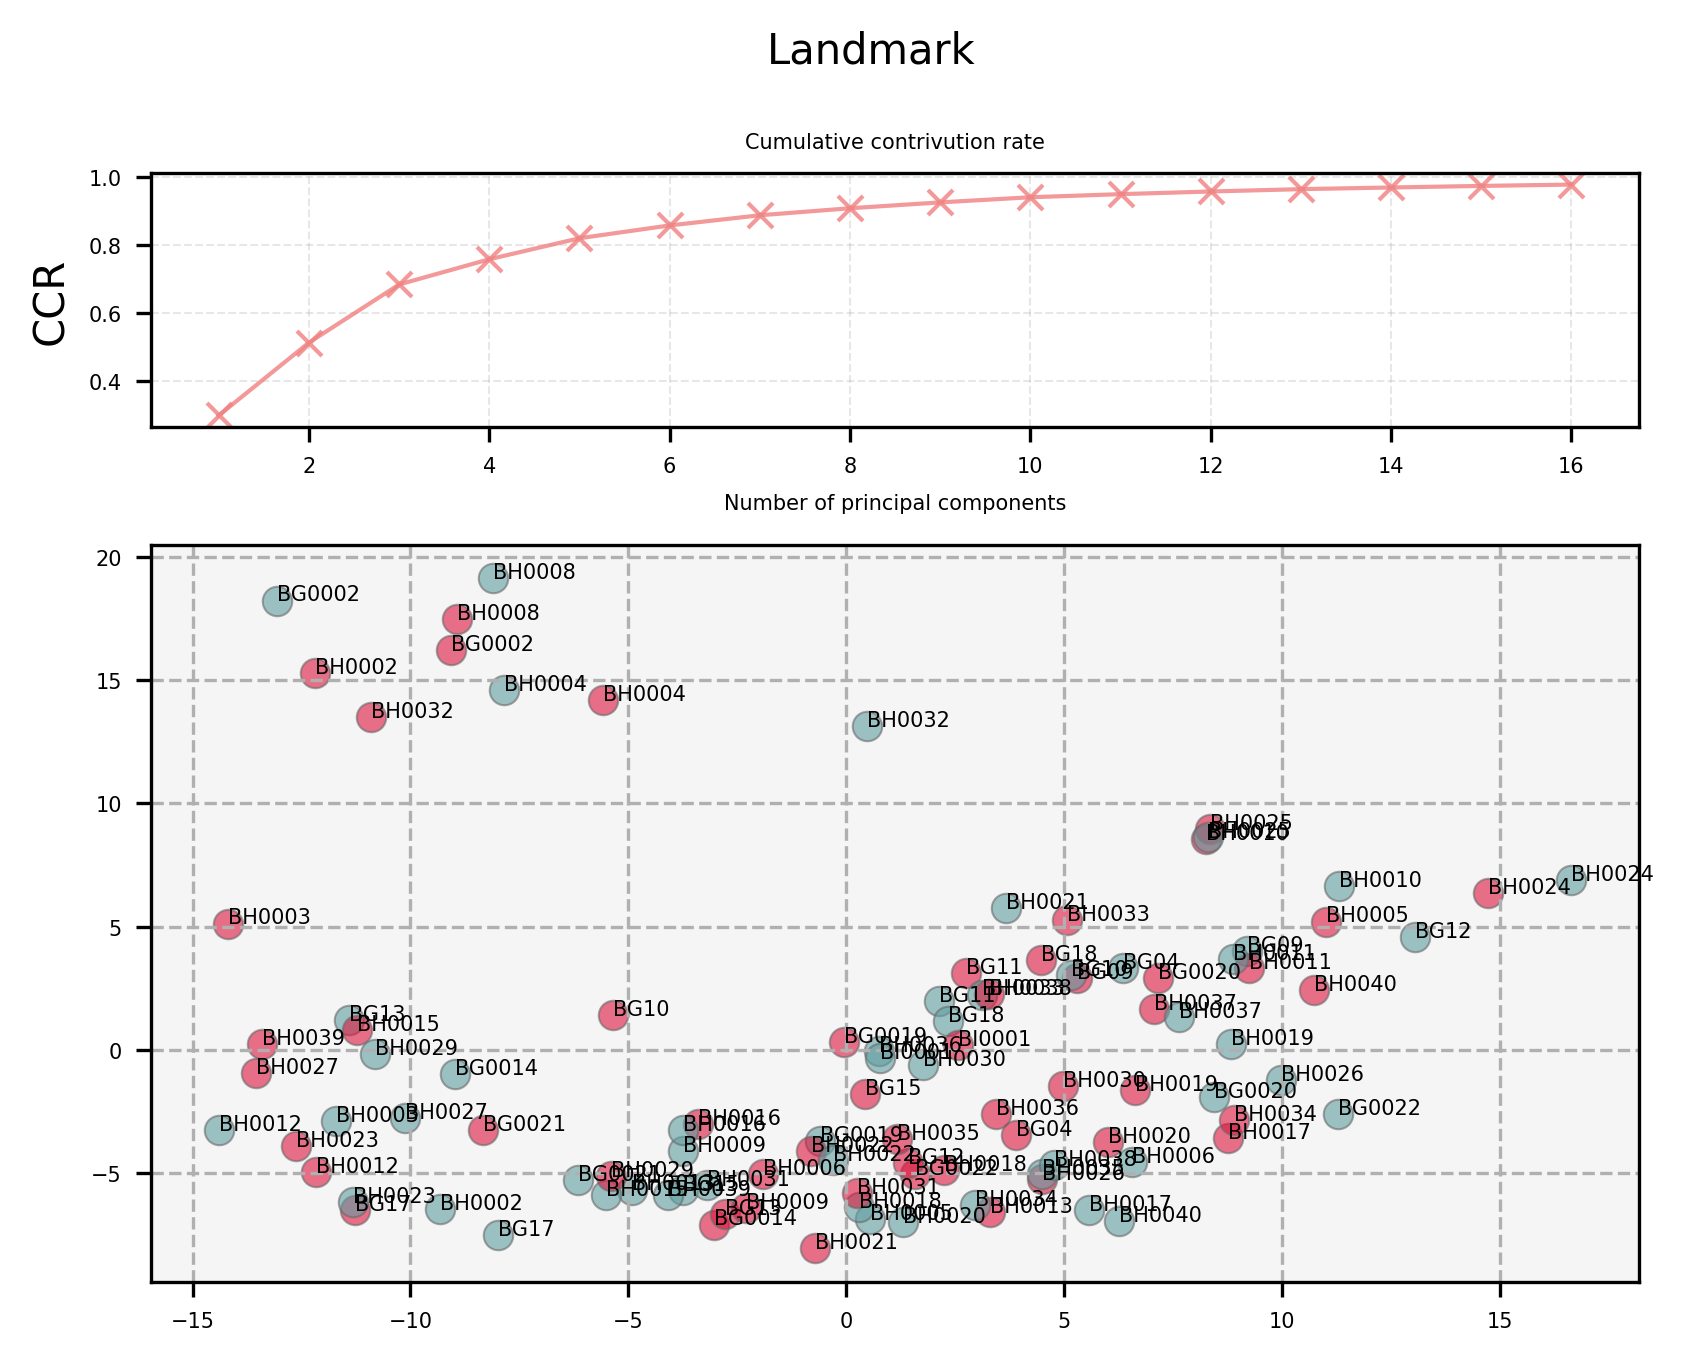

In [28]:
# 標準化

trio = np.append(aligned_pts[:,:,0], np.append(aligned_pts[:,:,1],
                                               aligned_pts[:,:,2],axis=1),axis=1)
# mean = np.mean(trio, axis=0)
# std = np.std(trio, axis=0)

trio_std_raw = zscore(trio,axis=0)
# quad_std = np.append(X_std,Z_std,axis=1)
print (trio_std_raw.shape)


fig = plt.figure(dpi=300)
fig.suptitle("Landmark", fontsize=10)
gs1 = fig.add_gridspec(nrows=30, ncols=20)
ax0 = fig.add_subplot(gs1[0:7, :])
ax = fig.add_subplot(gs1[10:, :])
for a in [ax0, ax]:
    a.tick_params(axis='both', which='major', labelsize=5)
    a.tick_params(axis='both', which='minor', labelsize=4) 

pca = PCA(n_components=16)
feature_raw = pca.fit_transform(trio_std_raw)
# reconstructed = pca.inverse_transform(feature)
cumsum_raw = list(np.cumsum(pca.explained_variance_ratio_))

ax0.plot(range(1, len(cumsum_raw)+1),cumsum_raw, "-x",alpha=0.8, linewidth=1, color='lightcoral')
#ax.set_xticks([])
ax0.set_xlabel("Number of principal components", fontsize=5)
ax0.set_ylabel("CCR") # ("Cumulative contribution rate")
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
ax0.set_title("Cumulative contrivution rate", fontsize=5)
ax0.grid(linestyle = '--', linewidth = 0.5,alpha=0.3)


for i in range(len(files)):
    position = files[i].split("/")[-1][:-4].split("_")[1]
    # print (position)
    if position =="Left":
        scatter_color="crimson"
    else:
        scatter_color="cadetblue"
    ax.scatter(feature_raw[i,0], feature_raw[i,1],
            s = 50,
            color = scatter_color,
            edgecolor="dimgray",
            linewidths=0.5,
            alpha=0.6)

    ax.text(feature_raw [i,0], feature_raw [i,1],
            files[i].split("\\")[-1][:-4].split("_")[0],
            fontsize=5)
ax.set_facecolor("whitesmoke")
ax.grid(linestyle="--")
plt.tight_layout()

In [29]:
# SRVRを計算

sr = []
for i in range(len(aligned_pts)):
    sr_velocity = square_root_velocity(aligned_pts[i])
    sr.append(sr_velocity)

sr = np.array(sr)

To-do: 比较pts和aligned pts计算出的sr是否一样

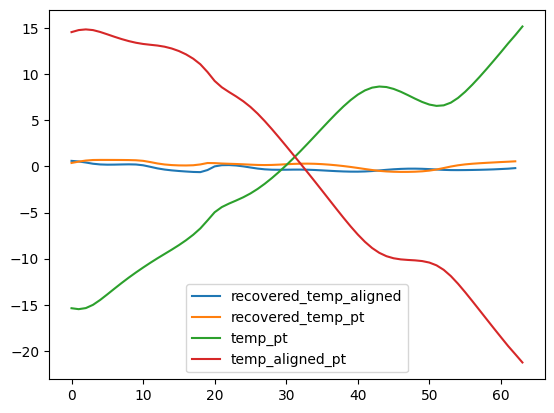

In [30]:
from scipy.integrate import cumtrapz

idx = 88

temp_aligned_pt = aligned_pts[idx]
temp_pt = pts[idx]

temp_aligned_sr = square_root_velocity(temp_aligned_pt)
temp_pt_sr = square_root_velocity(temp_pt)

# plt.plot(temp_aligned_sr[:,1])  
# plt.plot(-temp_pt_sr[:,1])

# 

recovered_temp_aligned = cumtrapz(temp_aligned_sr, initial=0)
recovered_temp_pt = cumtrapz(temp_pt_sr, initial=0)

plt.plot(recovered_temp_aligned[:,1],label="recovered_temp_aligned")  
plt.plot(-recovered_temp_pt[:,1],label="recovered_temp_pt")
plt.plot(-temp_pt[:,1],label="temp_pt")
plt.plot(temp_aligned_pt[:,1],label="temp_aligned_pt")
plt.legend()

In [31]:
# 標準化

trio_sr = np.append(sr[:,:,0], np.append(sr[:,:,1],sr[:,:,2],axis=1),axis=1)
mean = np.mean(trio_sr, axis=0)
std = np.std(trio_sr, axis=0)

trio_std = zscore(trio_sr,axis=0)
# quad_std = np.append(X_std,Z_std,axis=1)
print (trio_std.shape)


print (mean.shape, std.shape)

(104, 189)
(189,) (189,)


In [32]:
# Tangent PCA
# 设置Tangent PCA参数
n_neighbors = 65
n_components = 2
# 应用Tangent PCA进行降维
tangent_pca = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_components, method='ltsa')
X_tangent_pca = tangent_pca.fit_transform(trio_std)

C:\Users\cheno\AppData\Local\Temp\ipykernel_37300\2576161375.py:45: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


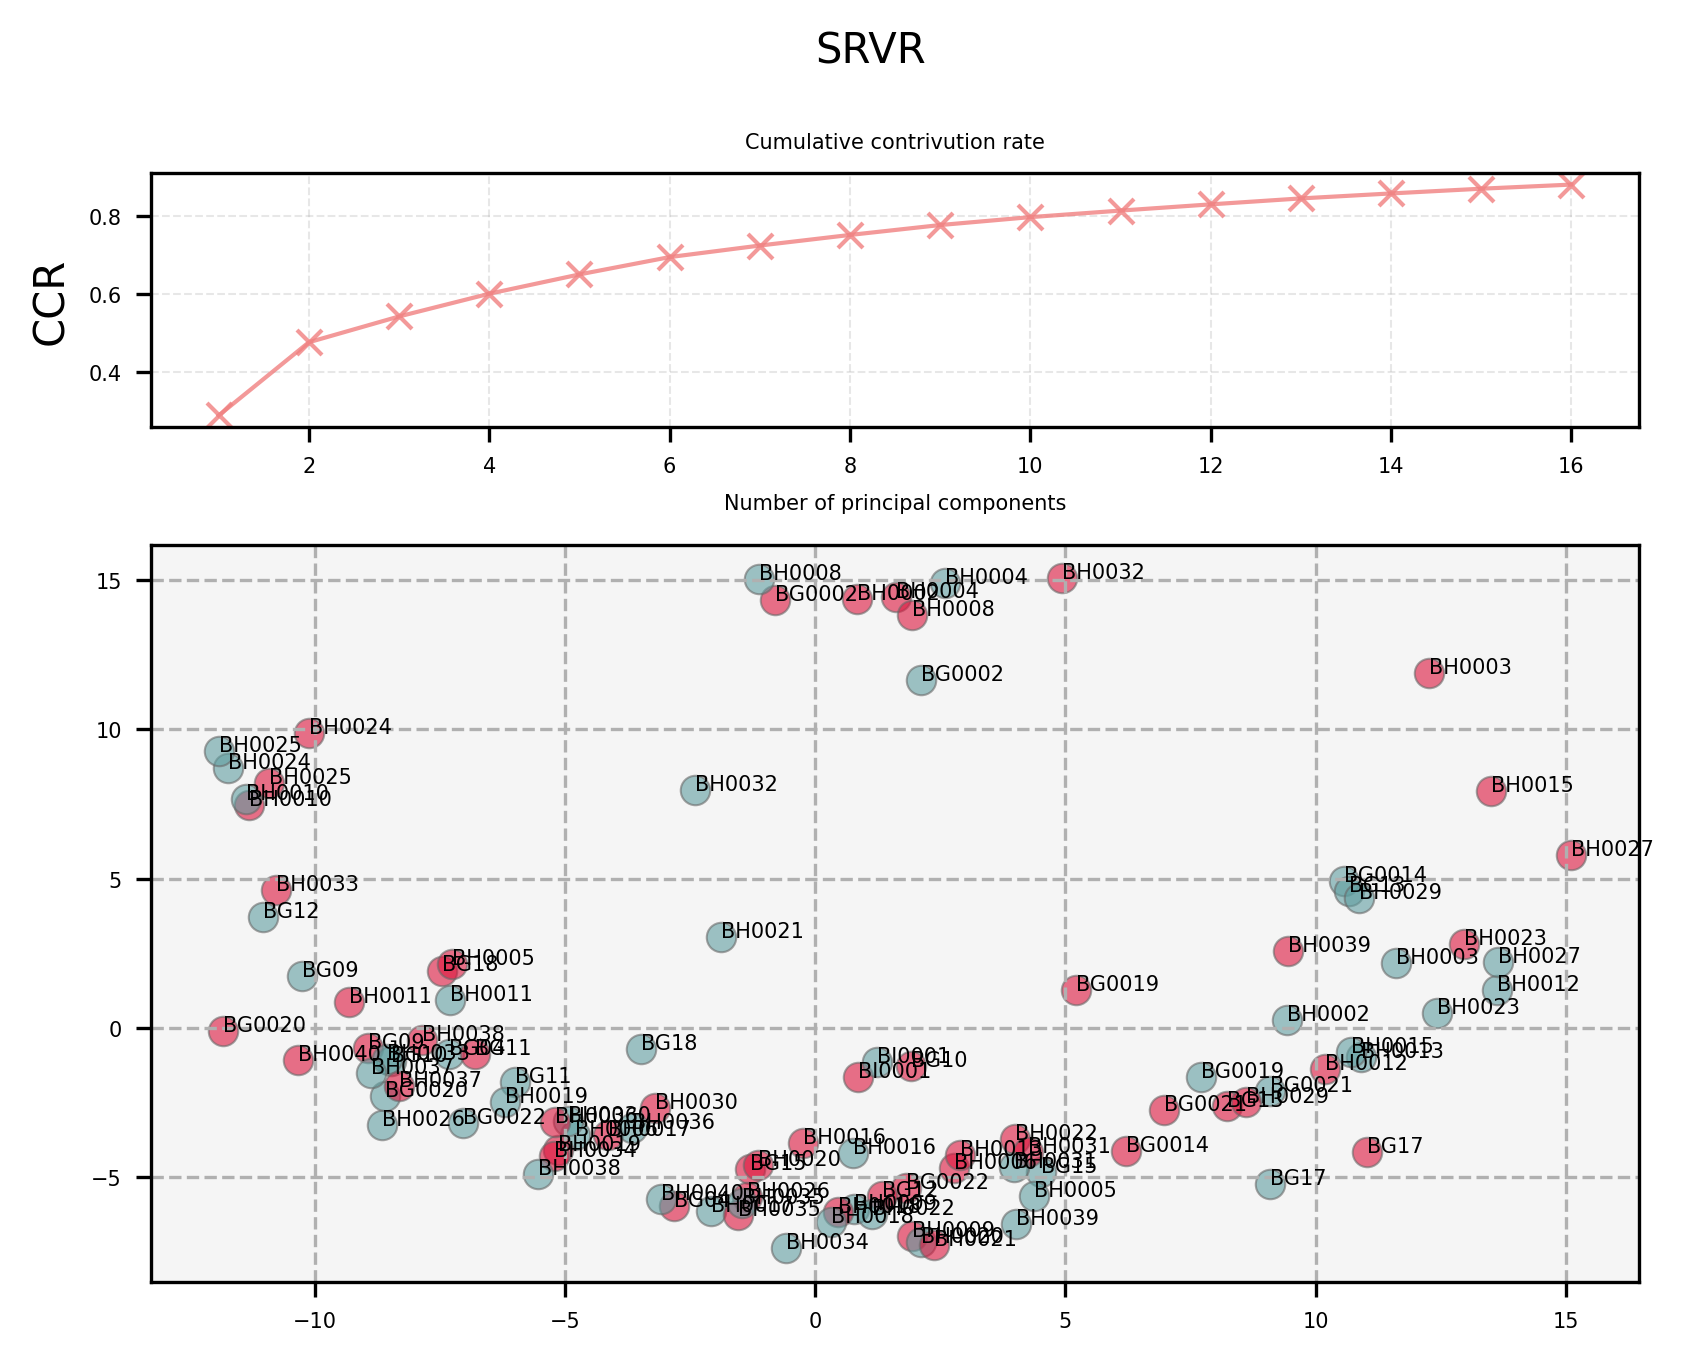

In [33]:
from sklearn.decomposition import PCA

fig = plt.figure(dpi=300)
fig.suptitle("SRVR", fontsize=10)
gs1 = fig.add_gridspec(nrows=30, ncols=20)
ax0 = fig.add_subplot(gs1[0:7, :])
ax = fig.add_subplot(gs1[10:, :])
for a in [ax0, ax]:
    a.tick_params(axis='both', which='major', labelsize=5)
    a.tick_params(axis='both', which='minor', labelsize=4) 

pca = PCA(n_components=16)
feature = pca.fit_transform(trio_std)
reconstructed = pca.inverse_transform(feature)
cumsum = list(np.cumsum(pca.explained_variance_ratio_))

ax0.plot(range(1, len(cumsum)+1),cumsum, "-x",alpha=0.8, linewidth=1, color='lightcoral')
#ax.set_xticks([])
ax0.set_xlabel("Number of principal components", fontsize=5)
ax0.set_ylabel("CCR") # ("Cumulative contribution rate")
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
ax0.set_title("Cumulative contrivution rate", fontsize=5)
ax0.grid(linestyle = '--', linewidth = 0.5,alpha=0.3)


for i in range(len(files)):
    position = files[i].split("/")[-1][:-4].split("_")[1]
    # print (position)
    if position =="Left":
        scatter_color="crimson"
    else:
        scatter_color="cadetblue"
    ax.scatter(feature[i,0], feature[i,1],
            s = 50,
            color = scatter_color,
            edgecolor="dimgray",
            linewidths=0.5,
            alpha=0.6)

    ax.text(feature[i,0], feature[i,1],
            files[i].split("\\")[-1][:-4].split("_")[0],
            fontsize=5)
ax.set_facecolor("whitesmoke")
ax.grid(linestyle="--")
plt.tight_layout()

In [36]:
np.save('./CUSV/srvr_feature.npy', feature)

print (files)

['./scaling/resamp_attr_ascii/vmtk64a\\BG0002_Left_new_new.vtk', './scaling/resamp_attr_ascii/vmtk64a\\BG0002_Right_new_new.vtk', './scaling/resamp_attr_ascii/vmtk64a\\BG0014_Left_new_new.vtk', './scaling/resamp_attr_ascii/vmtk64a\\BG0014_Right_new_new.vtk', './scaling/resamp_attr_ascii/vmtk64a\\BG0019_Left_new_new.vtk', './scaling/resamp_attr_ascii/vmtk64a\\BG0019_Right_new_new.vtk', './scaling/resamp_attr_ascii/vmtk64a\\BG0020_Left_new_new.vtk', './scaling/resamp_attr_ascii/vmtk64a\\BG0020_Right_new_new.vtk', './scaling/resamp_attr_ascii/vmtk64a\\BG0021_Left_new_new.vtk', './scaling/resamp_attr_ascii/vmtk64a\\BG0021_Right_new_new.vtk', './scaling/resamp_attr_ascii/vmtk64a\\BG0022_Left_new_new.vtk', './scaling/resamp_attr_ascii/vmtk64a\\BG0022_Right_new_new.vtk', './scaling/resamp_attr_ascii/vmtk64a\\BG04_Left_new_new.vtk', './scaling/resamp_attr_ascii/vmtk64a\\BG04_Right_new_new.vtk', './scaling/resamp_attr_ascii/vmtk64a\\BG09_Left_new_new.vtk', './scaling/resamp_attr_ascii/vmtk64a\\

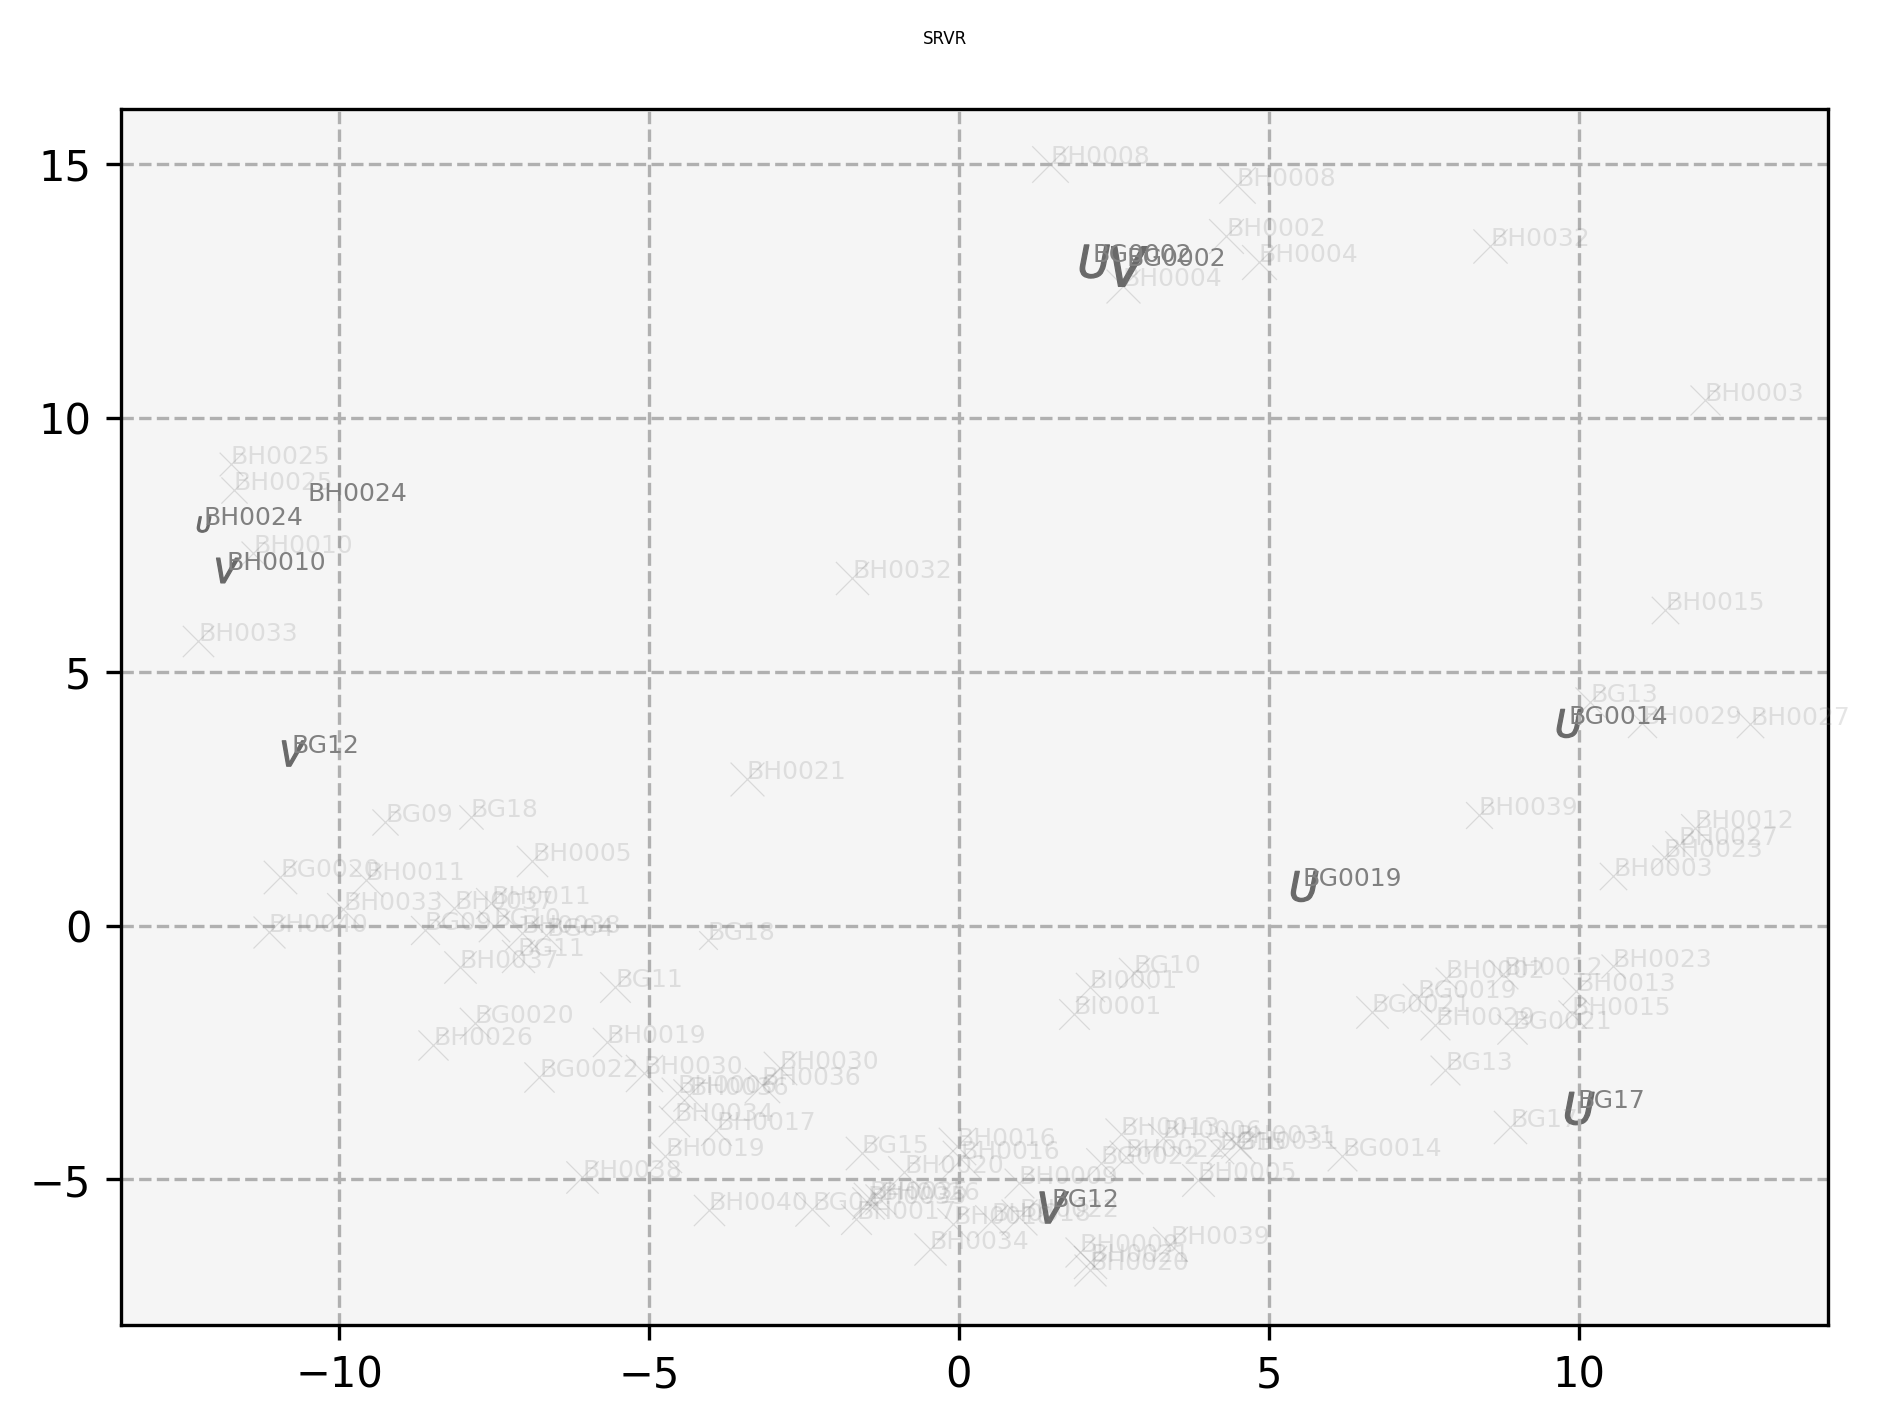

In [ ]:
from sklearn.decomposition import PCA


type_dict = {"BH0024_Right":"U",
             "BH0024_Left":"C",
             "BH0010_Right":"V",
             "BG17_Left":"U",
             "BG0019_Left":"U",
             "BG12_Right":"V",
             "BG12_Left":"V",
             "BG0002_Left":"U",
             "BG0002_Right":"V",
             "BG0014_Right":"U",
             }

fig = plt.figure(dpi=300)
fig.suptitle("SRVR", fontsize=4)
gs1 = fig.add_gridspec(nrows=20, ncols=20)
ax = fig.add_subplot(gs1[:, :])

for i in range(len(files)):
    name_idx = files[i].split("\\")[-1][:-12]
    if name_idx  not in type_dict.keys():
        alpha=0.2
        marker = "x"
    elif type_dict[name_idx] =="U":
        alpha=1.0
        marker = '$U$'
    elif type_dict[name_idx] =="C":
        alpha=1.0
        marker = '$C$'
    elif type_dict[name_idx] =="V":
        alpha=1.0
        marker = '$V$'
    ax.scatter(feature[i,0], feature[i,1],
            s = np.sqrt(feature[i,2]+abs(min(feature[:,2])))*20.0,
            color = "dimgray",
            linewidths=0.3,
            alpha=alpha,
            marker=marker,)
    ax.text(feature[i,0], feature[i,1],
            files[i].split("\\")[-1][:-4].split("_")[0],
            fontsize=6,
            alpha=alpha,
            color="gray")
ax.set_facecolor("whitesmoke")
ax.grid(linestyle="--")
plt.tight_layout()



In [ ]:
i =3

print ((feature[i,2]+abs(min(feature[:,2])))*12.0)

63.985531004424196


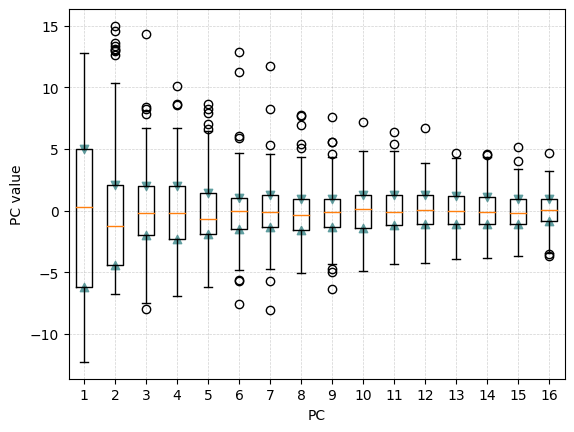

In [ ]:
ax = plt.boxplot(feature)
plt.xlabel("PC")
plt.ylabel("PC value")
q1s=[]
q3s=[]

for i in range(feature.shape[1]):
    plt.scatter(i+1,np.quantile(a=feature[:,i],q=0.25),marker="^", color="cadetblue")
    plt.scatter(i+1,np.quantile(a=feature[:,i],q=0.75),marker="v", color="cadetblue")
    q1s.append(np.quantile(a=feature[:,i],q=0.25))
    q3s.append(np.quantile(a=feature[:,i],q=0.75))
plt.grid(color = 'dimgray', linestyle = '--', linewidth = 0.5,alpha=0.3)
# plt.savefig("experiment_note/img/boxplot.png")

In [ ]:
# Initialize the class object
kmeans = KMeans(n_clusters= 4)
#predict the labels of clusters.
label = kmeans.fit_predict(X_tangent_pca)
#Getting unique labels
u_labels = np.unique(label)


fig = plt.figure()
ax = fig.add_subplot(111)
# plt.scatter(X_tangent_pca[:, 0], X_tangent_pca[:, 1])
for i in  u_labels:
    ax.scatter(X_tangent_pca[label == i , 0] , X_tangent_pca[label == i , 1] , label = i , marker="x")



# # 计算原始数据的均值和标准差
mean = np.mean(extracted_trio_sr, axis=0)
std = np.std(extracted_trio_sr, axis=0)

print ("mean and std of extracted_trio_pts:",mean.shape, std.shape)


# # 使用scipy的zscore函数进行标准化处理
# extracted_trio_pts = zscore(extracted_trio_pts, axis=0)

# # coef = np.polyfit(X_tangent_pca[:,0], X_tangent_pca[:,1], 3)
# # y_fit = np.polyval(coef, X_tangent_pca[:,0])
# # y = X_tangent_pca[:,1]
# # ax.scatter(X_tangent_pca[:,0], y_fit, alpha=0.5)

ax.set_title('2D Data after Tangent PCA (LTSA)')
plt.legend()
plt.grid(linestyle=":")

NameError: name 'KMeans' is not defined

每次运行时都要检测ulabel！！！！！

# 

In [ ]:
for i in u_labels:
    print ("cluster:", i)
    for j in range(len(files)):
        if label[j] == i:
            print (files[j].split("\\")[-1].split("_")[0], 
                   files[j].split("\\")[-1].split("_")[1][:-4])

cluster: 0
BG0020 Left
BG0020 Right
BG0022 Right
BG04 Right
BG09 Left
BG09 Right
BG10 Right
BG11 Left
BG11 Right
BG12 Right
BG18 Left
BG18 Right
BH0005 Left
BH0010 Left
BH0010 Right
BH0011 Left
BH0011 Right
BH0019 Right
BH0021 Right
BH0024 Left
BH0024 Right
BH0025 Left
BH0025 Right
BH0026 Right
BH0033 Left
BH0033 Right
BH0037 Left
BH0037 Right
BH0038 Left
BH0040 Left
cluster: 1
BG0014 Left
BG0019 Left
BG0022 Left
BG04 Left
BG10 Left
BG12 Left
BG15 Left
BG15 Right
BH0005 Right
BH0006 Left
BH0006 Right
BH0009 Left
BH0009 Right
BH0013 Left
BH0016 Left
BH0016 Right
BH0017 Left
BH0017 Right
BH0018 Left
BH0018 Right
BH0019 Left
BH0020 Left
BH0020 Right
BH0021 Left
BH0022 Left
BH0022 Right
BH0026 Left
BH0030 Left
BH0030 Right
BH0031 Left
BH0031 Right
BH0034 Left
BH0034 Right
BH0035 Left
BH0035 Right
BH0036 Left
BH0036 Right
BH0038 Right
BH0039 Right
BH0040 Right
BI0001 Left
BI0001 Right
cluster: 2
BG0002 Left
BG0002 Right
BH0002 Left
BH0004 Left
BH0004 Right
BH0008 Left
BH0008 Right
BH0032 Le

coef: [ 8.19772167e+01 -1.83118812e+01  5.76892357e+00  3.61021922e-01
 -7.96198212e-02]
reconstruction_error: 0.2703480275073743


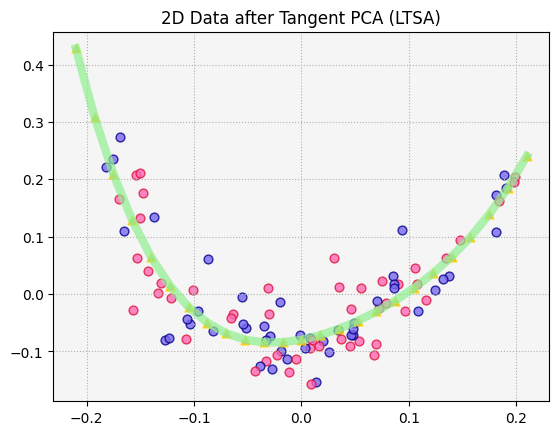

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)



# 设置Tangent PCA参数
n_neighbors = 60
n_components = 2

# 应用Tangent PCA进行降维
tangent_pca = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_components, method='ltsa')
X_tangent_pca = tangent_pca.fit_transform(extracted_trio_sr)

for j in range(len(extracted_files)):
    color_l = "mediumslateblue"
    color_r = "hotpink"
    edgec_l = "darkblue"
    edgec_r = "crimson"
    if "Right" in extracted_files[j]:
        color = color_r
        edgecolor = edgec_r
    else: 
        color = color_l
        edgecolor = edgec_l
    ax.scatter(X_tangent_pca[j , 0] , X_tangent_pca[j, 1] , 
            s = 40, marker="o" ,color= color, alpha=0.8,
            edgecolor=edgecolor,)
            # label="tangent PCA")

coef = np.polyfit(X_tangent_pca[:,0], X_tangent_pca[:,1], 4)
# y_fit = np.polyval(coef, X_tangent_pca[:,0])
x_test = np.linspace(-0.21, 0.21, 25)
y_fit = np.polyval(coef, x_test)
y = X_tangent_pca[:,1]
ax.plot(x_test, y_fit, alpha=0.7, color="lightgreen", marker="+", linewidth=6, label="quadratic fitting")

# for j in range(len(extracted_files)):
#     ax.text(X_tangent_pca[j , 0] , X_tangent_pca[j, 1] ,
#             '{}'.format(extracted_files[j].split("\\")[-1][:-4]))
ax.set_title('2D Data after Tangent PCA (LTSA)')
# plt.legend()
plt.grid(linestyle=":")
ax.set_facecolor("whitesmoke")

print ("coef:", coef)

# 使用线性回归实现LLE逆变换
linear_regression = LinearRegression(fit_intercept=False)
linear_regression.fit(X_tangent_pca, extracted_trio_sr)

data_reconstructed = linear_regression.predict(X_tangent_pca)
reconstruction_error = mean_squared_error(extracted_trio_sr, data_reconstructed)

print ("reconstruction_error:",reconstruction_error)

for j in range(len(x_test)):
    ax.scatter(x_test[j] , y_fit[j] , 
            s = 40, marker="^" ,color= "orange", alpha=0.8,
            edgecolor="gold",)
            # label="tangent PCA")

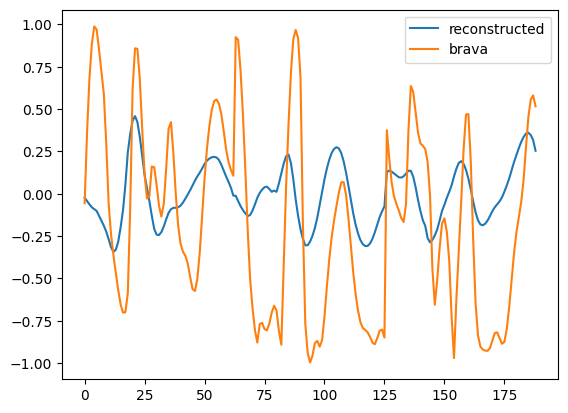

In [ ]:
plt.plot(data_reconstructed[16], label="reconstructed")
plt.plot(extracted_trio_sr[16],label="brava")
plt.legend()

generating in directory ./quadratic_synthetic\...
(25, 63, 3)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


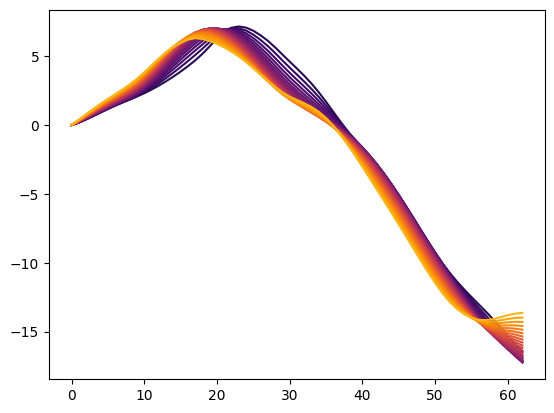

In [ ]:
from myvtk.General import mkdir

quadratic_synthetic_dir = mkdir("./","quadratic_synthetic")

import matplotlib
from scipy.integrate import cumtrapz

cmap = matplotlib.cm.get_cmap("inferno")

synthetic = np.stack([x_test, y_fit]).T
synthetic_reconstructed = linear_regression.predict(synthetic)

synthetic_recovered = synthetic_reconstructed * std + mean


syn_recoverd_3d = []
for i in range(synthetic_recovered.shape[0]):
    syn_recoverd_3d.append(np.stack([synthetic_recovered[i,:63], 
                                    synthetic_recovered[i,63:63*2], 
                                    synthetic_recovered[i,63*2:63*3]]).T)
syn_recoverd_3d = np.array(syn_recoverd_3d)
print (syn_recoverd_3d.shape)

print (np.ones(62))

scalarAttribute= [['MaximumInscribedSphereRadius', 'float', np.ones(64)]]
q0=np.zeros_like(synthetic_recovered[i,:63])
for i in range(synthetic_recovered.shape[0]):
    # plt.plot(syn_recoverd_3d[i,:,2], color=cmap((i+5)/(synthetic_recovered.shape[0]+10)))
    # synthetic_curve = np.vstack((q0, cumtrapz(synthetic_recovered[i,:63], initial=0))) + q0
    synthetic_x = cumtrapz(synthetic_recovered[i,:63], initial=0)
    synthetic_y = cumtrapz(synthetic_recovered[i,63:63*2], initial=0)
    synthetic_z = cumtrapz(synthetic_recovered[i,63*2:63*3], initial=0)
    plt.plot(synthetic_z, color=cmap((i+5)/(synthetic_recovered.shape[0]+10)))

    syn_recoverd_3d = np.stack([synthetic_x , 
                                synthetic_y , 
                                synthetic_z]).T



    makeVtkFile(savePath = "./quadratic_synthetic/{}.vtk".format(round(x_test[i], 3)),
                coords = syn_recoverd_3d, 
                scalarAttributes=scalarAttribute,
                fieldAttributes = [])



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Synthetic length: 51.45493120891025
Synthetic length: 50.09618259795445
Synthetic length: 50.96945233265967
Synthetic length: 50.63171805433603
Synthetic length: 50.36173833354309
Brava length: 64.00325582069866


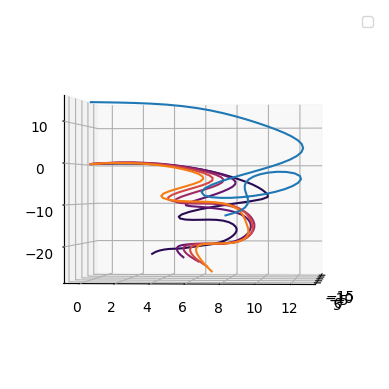

In [ ]:
ax = plt.figure().add_subplot(projection='3d')


for i in  range(0, synthetic_recovered.shape[0], 5):
    # plt.plot(syn_recoverd_3d[i,:,2], color=cmap((i+5)/(synthetic_recovered.shape[0]+10)))
    # synthetic_curve = np.vstack((q0, cumtrapz(synthetic_recovered[i,:63], initial=0))) + q0
    synthetic_x = cumtrapz(synthetic_recovered[i,:63], initial=0)
    synthetic_y = cumtrapz(synthetic_recovered[i,63:63*2], initial=0)
    synthetic_z = cumtrapz(synthetic_recovered[i,63*2:63*3], initial=0)
    # plt.plot(synthetic_x, color=cmap((i+5)/(synthetic_recovered.shape[0]+10)))
    ax.plot(synthetic_x, synthetic_y, synthetic_z, zdir='x', color=cmap((i+5)/(synthetic_recovered.shape[0]+10)))
    synthetic_i= np.stack([synthetic_x, synthetic_y, synthetic_z]).T
    print ("Synthetic length:", measure_length(synthetic_i))

# Make legend, set axes limits and labels
ax.legend()
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
# ax.set_zlim(0, 1)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
ax.plot(aligned_pts[0][:,2]-aligned_pts[0][0,2],aligned_pts[0][:,0]-aligned_pts[0][0,0],aligned_pts[0][:,1])
print ("Brava length:", measure_length(aligned_pts[0]))


# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
ax.view_init(elev=0, azim=5, roll=0)


plt.show()

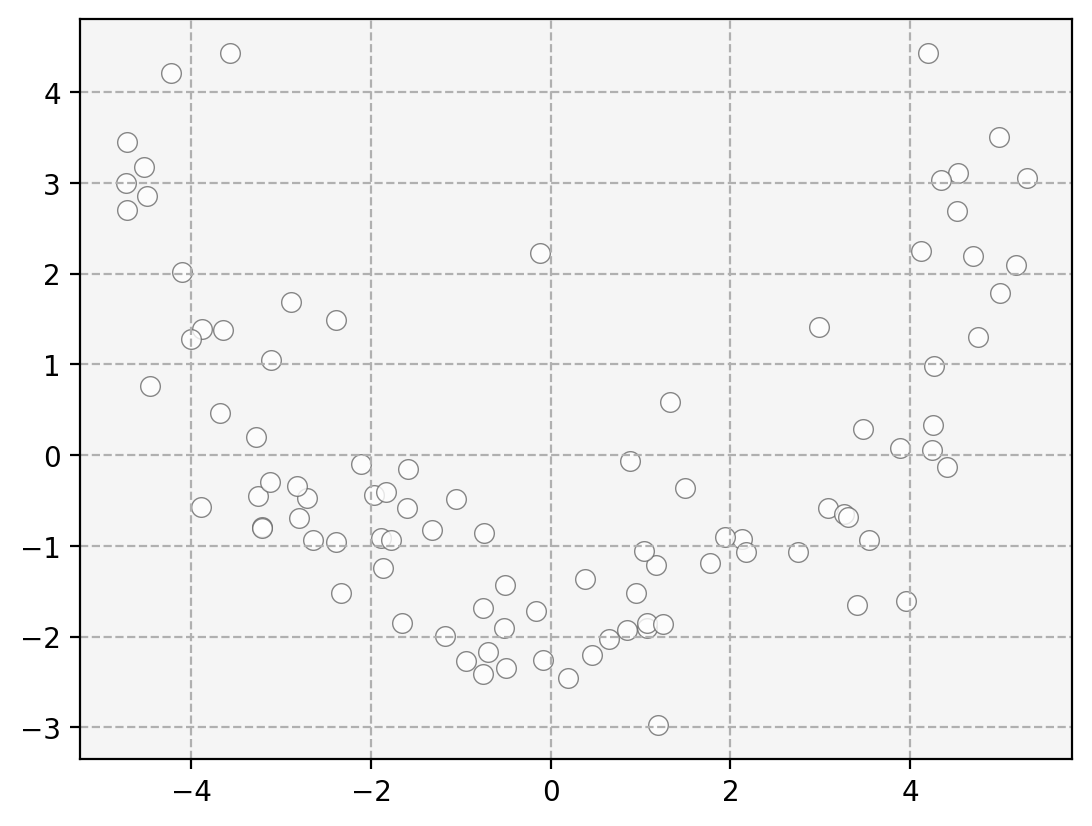

In [ ]:
pca = PCA(n_components=6)
feature = pca.fit_transform(extracted_trio_sr)
reconstructed = pca.inverse_transform(feature)

fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)

ax.scatter(feature[:,0], feature[:,1],
           s = 50,
           color = "white",
           edgecolor="dimgray",
           linewidths=0.5,
           alpha=0.8)
ax.set_facecolor("whitesmoke")
ax.grid(linestyle="--")

In [ ]:
from myvtk.srv import *

idx  = 10
f_transform_numpy(aligned_pts[idx])

IndexError: boolean index did not match indexed array along dimension 0; dimension is 63 but corresponding boolean dimension is 191